In [1]:
#resonance.ipynb
#by Joe Hahn, jmh.datasciences@gmail.com, 20 January 2024.
#plot motion of non-interacting particles at m=2 inner Lindblad resonance

In [2]:
#restore output
from helper_fns import *
execfile('inputs.py')
r, t, vr, vt, times, monitor = restore_output(output_folder)
a, e, wt, M = coords2elem(J2, Rp, r, t, vr, vt)
print 'r.shape = ', r.shape
print 'total_ring_mass = ', total_ring_mass
print 'shear_viscosity = ', shear_viscosity
print 'bulk_viscosity = ', bulk_viscosity
print 'initial_orbits = ', initial_orbits
print 'confine_inner_edge = ', confine_inner_edge
print 'confine_outer_edge = ', confine_outer_edge
print 'satellite = ', satellite
print 'e.min() = ', e.min()
print 'e.max() = ', e.max()
print 'execution time (min) = ', (monitor['current_time'] - monitor['start_time'])/60.0
print 'monitor = ', monitor

r.shape =  (1001, 64, 8)
total_ring_mass =  3.45419683059e-10
shear_viscosity =  -1e-13
bulk_viscosity =  -1e-13
initial_orbits =  {'shape': 'circular'}
confine_inner_edge =  False
confine_outer_edge =  False
satellite =  {'time_grow': 1000000.0, 'm': 2, 'mass_final': 6.5969e-08, 'r': 1.5815115989527513, 'mass': 0.0, 't': 0.0}
e.min() =  0.0
e.max() =  0.0014117069552874468
execution time (min) =  42.3333333333
monitor =  {'current_time': 1745795509, 'streamline_crossing_timestep': 28617, 'start_time': 1745792969, 'modified_params': None, 'nan_timestep': None, 'current_timestep': 2000000, 'self_interacting': False}


In [3]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
color_seq = plt.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib import rcParams
import numpy as np
import pandas as pd

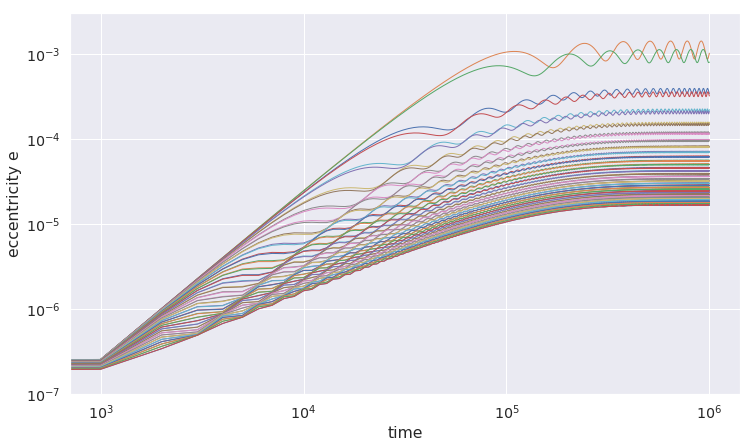

In [4]:
#plot each streamline's eccentricity versus time
sns.set(font_scale=1.3, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(12, 7))
e_mean = e.mean(axis=2).T
for e_streamline in e_mean:
    x = times
    y = e_streamline
    p = ax.plot(x, y, linestyle='-', linewidth=1)
p = ax.set_xlabel('time')
p = ax.set_ylabel('eccentricity e')
p = ax.set_ylim(1.0e-7, 3.0e-3)
p = ax.set_xscale('log')
p = ax.set_yscale('log')

In [5]:
#compute frequency distance from resonance
Kap = Kappa(J2, Rp, a)
Omg = Omega(J2, Rp, a)
m = satellite['m']
a_s = satellite['r']
Omg_s = Omega(J2, Rp, a_s)
wm = m*(Omg - Omg_s)
D = Kap**2 - wm**2

In [6]:
#find resonance radius
a_final = a[-1].mean(axis=1)
D_final = D[-1].mean(axis=1)
Omg_final = Omg[-1].mean(axis=1)
wm_final = wm[-1].mean(axis=1)
coeffs = np.polyfit(a_final, D_final, 1)
print 'coeffs = ', coeffs
a_res = np.roots(coeffs)[0]
print 'a_res = ', a_res

coeffs =  [ 3.03505534 -3.04112724]
a_res =  1.0020005890767008


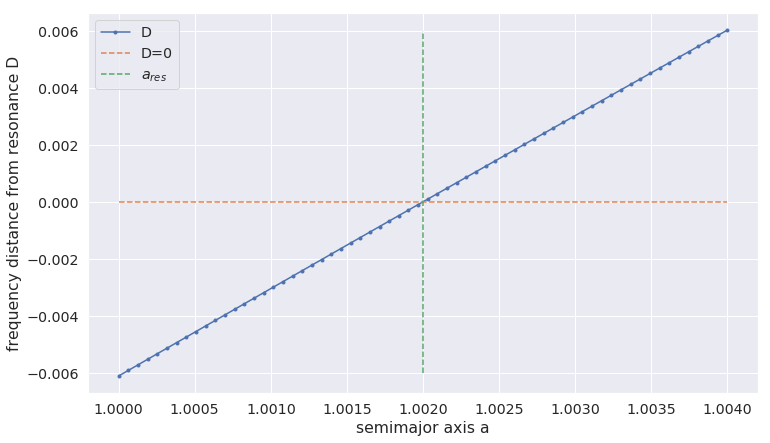

In [7]:
#plot D versus a
x = a_final
y = D_final
sns.set(font_scale=1.3, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(12, 7))
p = ax.plot(x, y, linestyle='-', marker='o', markersize=3, label='D')
y = x*0
p = ax.plot(x, y, linestyle='dashed', label='D=0')
x = [a_res, a_res]
y = [-0.006, 0.006]
p = ax.plot(x, y, linestyle='dashed', label=r'$a_{res}$')
p = ax.set_xlabel('semimajor axis a')
p = ax.set_ylabel('frequency distance from resonance D')
p = plt.legend()

In [8]:
times/1.0e7

array([0.    , 0.0001, 0.0002, ..., 0.0998, 0.0999, 0.1   ])

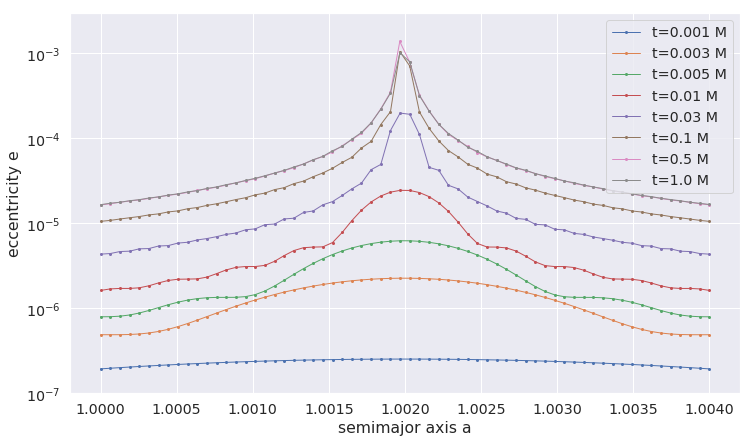

In [9]:
#plot eccentricity versus semimajor axis at selected times
sns.set(font_scale=1.3, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(12, 7))
plot_times = np.array([1.0e4, 3.0e4, 5.0e4, 1.0e5, 3.0e5, 1.0e6, 5.0e6, 1.0e7])/10
for plot_time in plot_times:
    t_idx = np.where(times >= plot_time)[0][0]
    a_now = a[t_idx]
    e_now = e[t_idx]
    time_now = times[t_idx]
    a_mean = a_now.mean(axis=1)
    e_mean = e_now.mean(axis=1)
    x = a_mean
    y = e_mean
    label = 't=' + str(time_now/1.0e6) + ' M'
    p = ax.plot(x, y, linestyle='-', linewidth=1, marker='o', markersize=2, label=label)
p = ax.set_xlabel('semimajor axis a')
p = ax.set_ylabel('eccentricity e')
p = ax.set_ylim(1.0e-7, 3.0e-3)
p = ax.set_yscale('log')
p = plt.legend()

In [10]:
#compute laplace coefficients
from helper_fns import *
beta = a_final.mean()/satellite['r']
m = satellite['m']
s = 0.5
laplace_coeff = lc(beta, m, s)
dlaplace_coeff = dlc(beta, m, s)
laplace_coeff, dlaplace_coeff

(0.37061847363596107, 1.4782644552902013)

In [11]:
#calculate forced eccentricty
a_now = a[-1]
e_now = e[-1]
a_mean = a_now.mean(axis=1)
e_mean = e_now.mean(axis=1)
m = satellite['m']
a_sat = satellite['r']
mass_sat = satellite['mass_final']
beta = a_mean/a_sat
forcing_fn = dlaplace_coeff + 2*m*(Omg_final/wm_final)*laplace_coeff/beta
forcing_fn *= mass_sat/(a_sat**2)
e_forced = np.abs(forcing_fn/(a_final*D_final))

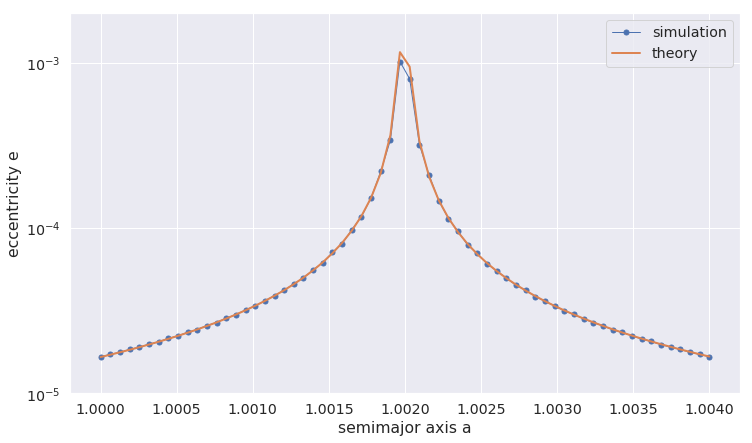

In [12]:
#plot final e versus a and compare to linearized theory
sns.set(font_scale=1.3, font='DejaVu Sans')
f, ax = plt.subplots(figsize=(12, 7))
x = a_mean
y = e_mean
p = ax.plot(x, y, linestyle='-', linewidth=1, marker='o', markersize=5, label='simulation')
y = e_forced
p = ax.plot(x, y, linestyle='-', linewidth=2, marker='o', markersize=0, label='theory')
p = ax.set_xlabel('semimajor axis a')
p = ax.set_ylabel('eccentricity e')
p = ax.set_ylim(1.0e-5, 2.0e-3)
p = ax.set_yscale('log')
p = plt.legend()

In [13]:
satellite

{'m': 2,
 'mass': 0.0,
 'mass_final': 6.5969e-08,
 'r': 1.5815115989527513,
 't': 0.0,
 'time_grow': 1000000.0}

In [14]:
beta.mean()

0.6335710464128177